# A Picture Can Speak A Thousand Words

> `Picture abhi baaki hai mere dost`

<a id = 'toc'></a>
## Table of Contents

1. [Import Libraries](#import)
2. [Load Metadata](#load_metadata)
3. [Clean Metadata](#clean_metadata)
4. [Convert to Appropriate Form](#convert_to_form)
5. [Load Plot Summaries](#load_plot)
6. [Merge the Data](#merge)
7. [Write to a CSV File](#write)
8. [Data and Labels](#data_and_labels)<br>
    8.1. [Frequency Distribution of Genre Counts](#freq_distribution)<br>
    8.2 [Genre Distribution of Data](#genre_dist)<br>
    8.3 [Correlation Heatmap](#corr_heatmap)<br>
9. [Text Preprocessing](#text_preprocess)
10. [The Model](#model)
11. [Training the beast](#train)
12. [Checking on a stray example](#check)
13. [Reviewing the Precision](#precision)
14. [Checking on User Input](#user_input)
15. [The API bit](#api)

<a id = 'import'></a>
### [1. Import Libraries](#toc)
In this section we will load and install all the libraries that we will require in the course of this project

In [ ]:
!pip install pattern
!pip install transformers
!pip install -Uq grpcio==1.26.0

     |████████████████████████████████| 22.2 MB 6.6 MB/s 
     |████████████████████████████████| 88 kB 7.8 MB/s 
     |████████████████████████████████| 81 kB 2.6 MB/s 
     |████████████████████████████████| 5.6 MB 25.7 MB/s 
     |████████████████████████████████| 5.6 MB 33.5 MB/s 
     |████████████████████████████████| 419 kB 40.4 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 3.5 MB 32.8 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=196b7b6e4917c5698160fff5aff8d1e5f107c7235b1553edac30d327db7c6b91
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100143 sha256=14bd5282afd764449bbabe0a008fbaa3c4103569968d1b60c09315aadfdda23c
  Stored in directory: /root/.cache/pip/wheels/79/1c/f8/11fafab45fe6696eea63794a5d747b9c6b54990ac6f1885fb7
  C

In [ ]:
import json
import tarfile
import pandas as pd
import re
import string
import os
from tqdm import tqdm
from pattern.text.en import singularize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertModel
import numpy as np
import tempfile
import sys
import subprocess
from datetime import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = 'load_metadata'></a>
### [2. Load Metadata](#toc)
In this section, we will load the metadata

In [ ]:
def extract_file():
    """
    Extracts all contents of the tar file
    Args: None
    Returns: None
    """
    file = tarfile.open("/content/drive/MyDrive/Assignments/Capstone Project/Data/MovieSummaries.tar.gz", mode="r|gz")
    file.extractall(path = '/content/drive/MyDrive/Assignments/Capstone Project/Data')

In [ ]:
metadata_df = pd.read_csv('/content/drive/MyDrive/Assignments/Capstone Project/Data/movie.metadata.tsv', sep = '\t', header = None)
metadata_df.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


<a id = 'clean_metadata'></a>
### [3. Clean Metadata](#toc)
In this section, we will clean the metadata specifically the genres that it contains to make it more suitable for our application

In [ ]:
def create_list_genres(x):
  """
  Filters and cleans the genres present in the genre column
  Args: None
  Returns: List of genres
  """
  regex = re.compile('((film)s?)|((movie)s?)|((cinema)s?)|((piece)s?)|((period)s?)', re.IGNORECASE)
  x = regex.sub('', x)
  temp_res = list(json.loads(x).values())
  trans_table = {str(elem):' ' for elem in string.punctuation} 
  res = []
  for elem in temp_res:
      elem = elem.lower()
      
      #black-and-white movies turned to a single category grayscale
      regex_phrase = re.compile('black-and-white', re.IGNORECASE)
      elem = regex_phrase.sub('grayscale', elem)
      
      ##########################################################################################################
      
      trans_table = elem.maketrans(trans_table)
      elem = elem.translate(trans_table)
      
      ##########################################################################################################
      
      # combine chinese, indian, japanese movies into one category
      regex_region = re.compile('(chinese)|(japanese)|(bollywood)|(filipino)|(tollywood)|(bengali)', re.IGNORECASE)
      elem = regex_region.sub('asian', elem)
      
      # noir movies are basically crime, drama movies that are generally grayscale
      regex_phrase = re.compile('noir', re.IGNORECASE)
      elem = regex_phrase.sub('crime drama', elem)
      
      # anime and animated cartoons are basically animations
      regex_translate = re.compile('(anime)|(animat\S+)', re.IGNORECASE)
      elem = regex_translate.sub('animation', elem)
      
      # docudrama is a portmanteau of documentary and drama
      regex_translate = re.compile('docudrama', re.IGNORECASE)
      elem = regex_translate.sub('documentary drama', elem)
      
      # capture different versions of representing musical movies into a single genre
      regex_translate = re.compile('(musical)|(rock(\S+)?)|(concert)|(operetta)|(hip hop)', re.IGNORECASE)
      elem = regex_translate.sub('music', elem)
      
      # experimental movies are basically art films (ahead of their time)
      regex_translate = re.compile('experimental', re.IGNORECASE)
      elem = regex_translate.sub('art', elem)
      
      # spy movies involve elements of thrill, crime and action
      regex_translate = re.compile('spy', re.IGNORECASE)
      elem = regex_translate.sub('crime thriller action', elem)
      
      # mockumentary is a portmanteau of a mockery and a documentary
      regex_translate = re.compile('mockumentary', re.IGNORECASE)
      elem = regex_translate.sub('comedy documentary', elem)
      
      # zombie and slasher movies are a subset of horror movies
      regex_translate = re.compile('(zombie)|(slasher)', re.IGNORECASE)
      elem = regex_translate.sub('horror', elem)
      
      # combine the different ways to reference adult movies to a single category
      regex_adult = re.compile('(adult)|(sex(\S+)?)|(erotic(\S+)?)|(porn(\S+)?)', re.IGNORECASE)
      elem = regex_adult.sub('porn', elem)
      
      # swashbuckler are movies that comprise adventure and action scene
      regex_translate = re.compile('swashbuckler', re.IGNORECASE)
      elem = regex_translate.sub('adventure action', elem)
      
      regex_translate = re.compile('science[\s+]fiction', re.IGNORECASE)
      elem = regex_translate.sub('scifi', elem)
      
      # parody and satire are a subset of comedy movies
      regex_translate = re.compile('(parody)|(satire)', re.IGNORECASE)
      elem = regex_translate.sub('comedy', elem)
      
      # suspense and whodunit are synonymous with mystery movies
      regex_translate = re.compile('(suspense)|(whodunit)', re.IGNORECASE)
      elem = regex_translate.sub('mystery', elem)
      
      # the various ways of representing romance movies are condensed into a single category
      regex_similar_genres = re.compile('roman\S+')
      elem = regex_similar_genres.sub('romance', elem)
      
      # polical movies are collapsed into a single category
      regex_similar_genres = re.compile('politic\S+')
      elem = regex_similar_genres.sub('political', elem)
      
      # biographies are casted into a single category
      regex_similar_genres = re.compile('biograph\S+')
      elem = regex_similar_genres.sub('biographical', elem)
      
      # psychological movies turned into a single category
      regex_similar_genres = re.compile('psycholo\S+')
      elem = regex_similar_genres.sub('psychological', elem)
      
      ###########################################################################################################
      
      distinct_genres = elem.split()
      res.extend(distinct_genres)
      
  final_res = [singularize(genre) for genre in res]
  final_res = set(final_res)
  return final_res

In [ ]:
def get_frequent_genres(df, num_of_genres):
  """
  Get most frequently occuring genres
  Args:
  1) Metadata Dataframe
  2) Number of genres expected
  """
  df[9] = df[8].apply(lambda x: create_list_genres(x))
  temp = df[9].explode()
  temp = pd.crosstab(temp.index, temp)
  genre_list = list(temp.sum(axis = 0).sort_values(ascending = False).head(num_of_genres).index)
  return genre_list

In [ ]:
def retain_frequent_genres(movie_genres, genre_list):
  """
  Retains only those genres that are present in the genre list
  Args: 
  1) Movie genres filtered and cleaned
  2) List of permissible genres
  Returns:
  1) Filtered list of genres that are present in the genre list
  """
  res = []
  for genre in movie_genres:
      if genre in genre_list:
          res.append(genre)
          
  if len(res) == 0:
      return None
  return res

In [ ]:
genre_list = get_frequent_genres(metadata_df, 35)

In [ ]:
try:
    genre_list.remove('of')
    genre_list.remove('s')
except:
    pass

<a id = 'convert_to_form'></a>
### [4. Convert to Appropriate Form](#toc)
Metadata dataframe is converted to an appropriate one hot form for our model

In [ ]:
metadata_df[10] = metadata_df[9].apply(lambda x: retain_frequent_genres(x, genre_list))
metadata_df = metadata_df[metadata_df[10].notnull()]
create_label_columns = metadata_df[10].explode()
create_label_columns = pd.crosstab(create_label_columns.index, create_label_columns)
create_label_columns

10,action,adaptation,adventure,animation,art,asian,biographical,child,comedy,crime,...,psychological,romance,scifi,short,silent,sport,thriller,war,western,world
row_0,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81737,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81738,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_genre_df = pd.DataFrame()
movie_genre_df['Movie_ID'] = metadata_df[0]
movie_genre_df['Movie_Name'] = metadata_df[2]
movie_genre_df

,Movie_ID,Movie_Name
0,975900,Ghosts of Mars
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...
2,28463795,Brun bitter
3,9363483,White Of The Eye
4,261236,A Woman in Flames
...,...,...
81736,35228177,Mermaids: The Body Found
81737,34980460,Knuckle
81738,9971909,Another Nice Mess
81739,913762,The Super Dimension Fortress Macross II: Lover...


In [ ]:
movie_genres_df = pd.concat([movie_genre_df, create_label_columns], axis = 1)

<a id = 'load_plot'></a>
### [5. Load Plot Summaries](#toc)
We will load the plot summaries dataframe which serves as input to our model

In [ ]:
summary_df = pd.read_csv('./Data/plot_summaries.txt', sep = '\t', header = None)
summary_df.columns = ['Movie_ID','Movie_Summary']

<a id = 'merge'></a>
### [6. Merge the Data](#toc)
Finally the dataframes are merged in order to get the data that will be input to our model as well as labels for training it

In [ ]:
preprocessed_df = pd.merge(movie_genres_df, summary_df, how = 'inner', left_on = 'Movie_ID', right_on = 'Movie_ID')

column_order = list(preprocessed_df.columns[:2])
column_order.append(preprocessed_df.columns[-1])
column_order.extend(list(preprocessed_df.columns[2:-1]))

preprocessed_df = preprocessed_df[column_order]

In [ ]:
preprocessed_df.iloc[:, 3:].describe()

,action,adaptation,adventure,animation,art,asian,biographical,child,comedy,crime,...,psychological,romance,scifi,short,silent,sport,thriller,war,western,world
count,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,...,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000,41687.000000
mean,0.166431,0.029386,0.146568,0.062633,0.027754,0.085734,0.024468,0.025284,0.312136,0.135246,...,0.027323,0.174011,0.056181,0.076571,0.028762,0.016144,0.169141,0.037542,0.025188,0.123876
std,0.372471,0.168887,0.353679,0.242305,0.164270,0.279974,0.154499,0.156987,0.463370,0.341990,...,0.163024,0.379124,0.230273,0.265912,0.167139,0.126031,0.374881,0.190087,0.156697,0.329443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id = 'write'></a>
### [7. Write to a CSV File](#toc)
The final dataframe is stored in a csv file for convenience of use

In [ ]:
preprocessed_df.to_csv('/content/drive/MyDrive/Assignments/Capstone Project/Data/summary_and_labels.csv', index = False)

<a id = 'data_and_labels'></a>
### [8. Data and Labels](#toc)
Load the preprocessed dataframe in order to obtain the data and its labels

In [ ]:
preprocessed_df = pd.read_csv('/content/drive/MyDrive/Assignments/Capstone Project/Data/summary_and_labels.csv')
preprocessed_df.head()

,Movie_ID,Movie_Name,Movie_Summary,action,adaptation,adventure,animation,art,asian,biographical,child,comedy,crime,documentary,drama,family,fantasy,fiction,grayscale,horror,indie,lgbt,music,mystery,political,porn,psychological,romance,scifi,short,silent,sport,thriller,war,western,world
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th...",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,9363483,White Of The Eye,A series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
2,261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6631279,Little city,"Adam, a San Francisco-based artist who works a...",0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
data = preprocessed_df.loc[:, 'Movie_Summary'].to_numpy().reshape(-1, 1)
labels = preprocessed_df.iloc[:, 3:].to_numpy()

<a id = 'freq_distribution'></a>
#### [8.1 Frequency Distribution of Genre Counts](#toc)
Observed the number of genres that the examples usually contain

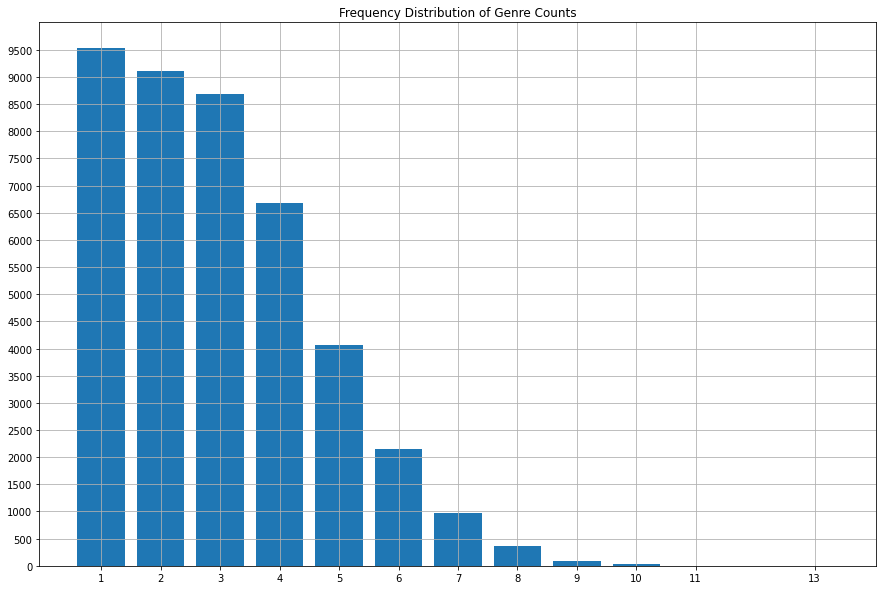

In [ ]:
unique, counts = np.unique(np.sum(labels, axis = 1), return_counts = True)
plt.figure(figsize = (15, 10))
plt.bar(unique, counts);
plt.xticks(unique);
plt.yticks(np.arange(0, 10000, 500))
plt.title('Frequency Distribution of Genre Counts');
plt.grid(axis = 'both')

<a id = 'genre_dist'></a>
#### [8.2 Genre Distribution of Data](#toc)
Observe the genres most frequent in our dataset

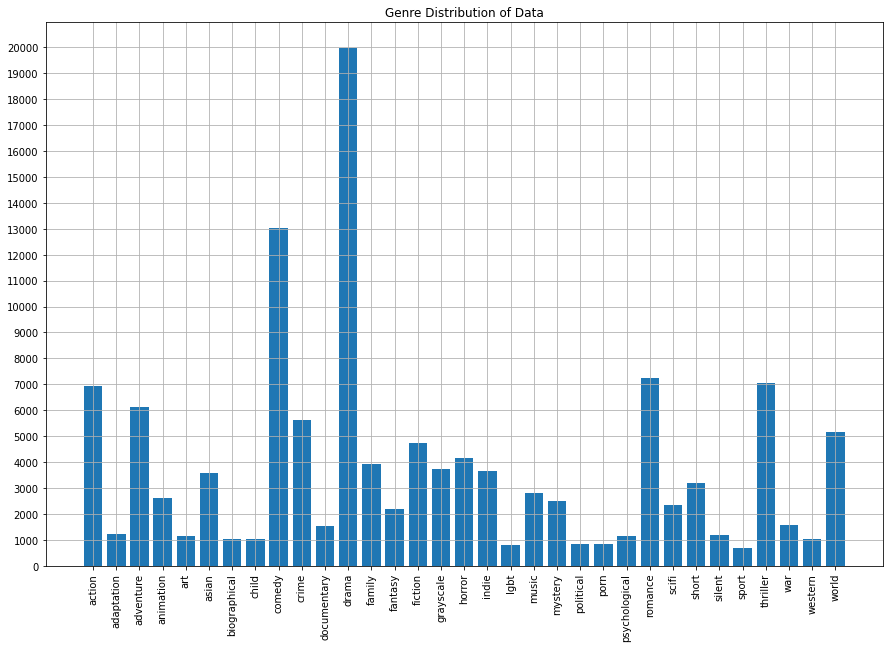

In [ ]:
plt.figure(figsize = (15, 10))
plt.bar(np.arange(1, 34, 1), np.sum(labels, axis = 0));
plt.xticks(np.arange(1,34,1), labels = preprocessed_df.iloc[:, 3:].columns, rotation = 90);
plt.yticks(np.arange(0, 21000, 1000))
plt.title('Genre Distribution of Data');
plt.grid(axis = 'both')

<a id = 'corr_heatmap'></a>
#### [8.3 Correlation Heatmap](#toc)
Observe the correlation between different genres

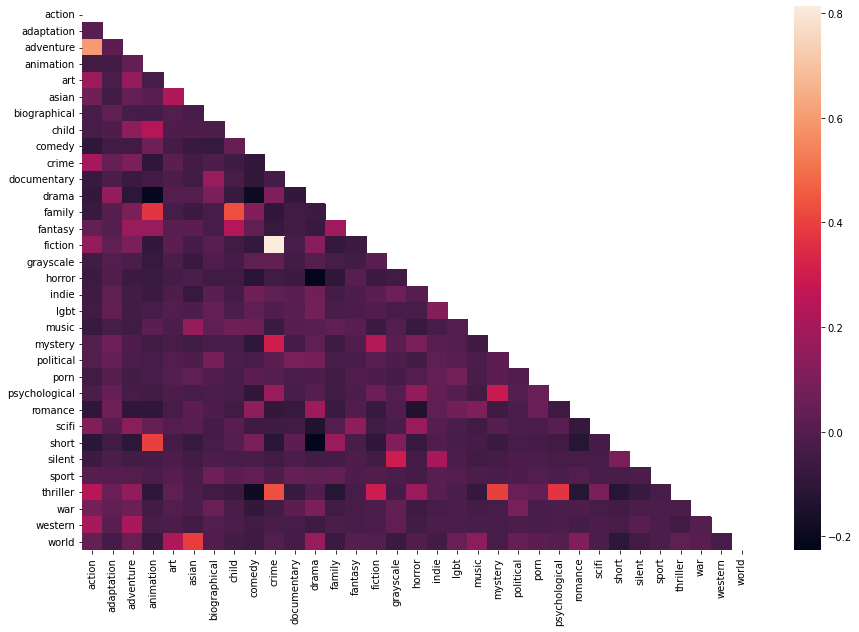

In [ ]:
plt.figure(figsize = (15, 10))
matrix_mask = np.triu(preprocessed_df.iloc[:, 3:].corr())
sns.heatmap(preprocessed_df.iloc[:, 3:].corr(), mask = matrix_mask);

Great! Barring a few genres, none of the genres have a really strong correlation with one another. This is really an illustration of the hard work that has gone into cleaning and merging several of the genres in order to make the final dataframe.

<a id = 'text_preprocess'></a>
### [9. Text Preprocessing](#toc)
Preprocess the text in order to be suitable for inputting into the model (defined later)

In [ ]:
mean_seq_length = preprocessed_df.Movie_Summary.str.split().str.len().mean()
print(f'Mean Sequence Length is {mean_seq_length}')

Mean Sequence Length is 311.737855926308


In [ ]:
median_seq_length = preprocessed_df.Movie_Summary.str.split().str.len().median()
print(f'Median Sequence Length is {median_seq_length}')

Median Sequence Length is 187.0


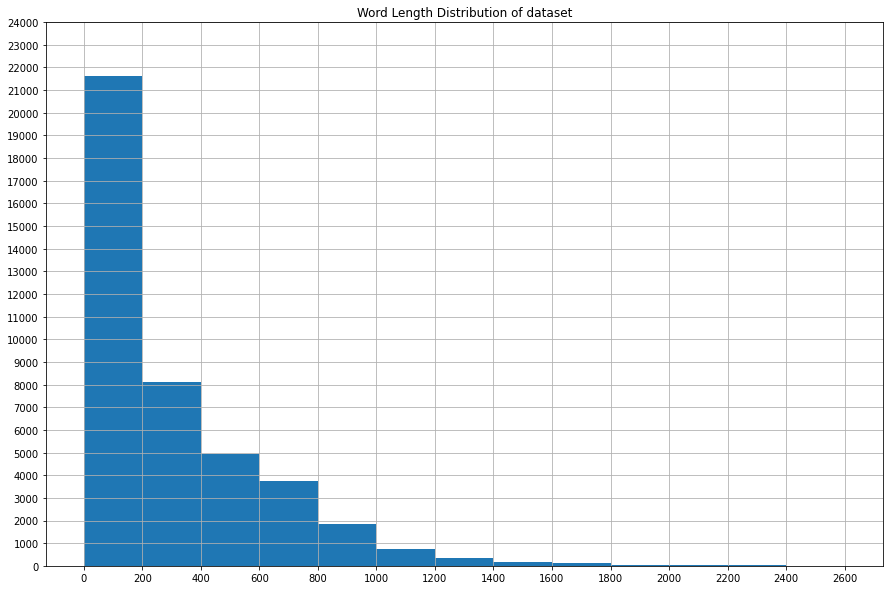

In [ ]:
dist = list(preprocessed_df.Movie_Summary.str.split().str.len())
plt.figure(figsize = (15,10));
plt.hist(dist, bins = np.arange(0, 2700, 200));
plt.xticks(np.arange(0, 2700, 200))
plt.yticks(np.arange(0, 25000, 1000))
plt.grid(axis = 'both')
plt.title('Word Length Distribution of dataset');

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(data,
                                                                  labels,
                                                                  random_state = 123,
                                                                  test_size = 0.2)
train_data = np.squeeze(train_data)
val_data = np.squeeze(val_data)
train_data = train_data.astype('str')
val_data = val_data.astype('str')

In [ ]:
#@title Tokenization (redundant)
def bert_encoding(data, max_length = 256):
  tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', 
                                                do_lower_case = True)
  
  tokens = tokenizer.batch_encode_plus(data.tolist(),
                                       max_length = max_length,
                                       padding = 'max_length',
                                       truncation = True, 
                                       return_token_type_ids = False)
  return tokens['input_ids'], tokens['attention_mask']

training_input_ids, training_attention_masks = bert_encoding(train_data)
val_input_ids, val_attention_masks = bert_encoding(val_data)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#@title Dataset Generator (slow method)
BATCH_SIZE = 8

def train_generator():
  for i in np.random.permutation(np.asarray(training_input_ids).shape[0]):
    yield {'input_ids': np.asarray(training_input_ids)[i], 'attention_masks': np.asarray(training_attention_masks)[i]}, train_labels[i]

def val_generator():
  for i in np.random.permutation(np.asarray(val_input_ids).shape[0]):
    yield {'input_ids': np.asarray(val_input_ids)[i], 'attention_masks': np.asarray(val_attention_masks)[i]}, val_labels[i]

train_ds = tf.data.Dataset.from_generator(train_generator, ({'input_ids':tf.int64, 'attention_masks': tf.int64}, tf.int64)).batch(BATCH_SIZE, drop_remainder = True)

val_ds = tf.data.Dataset.from_generator(val_generator, ({'input_ids':tf.int64, 'attention_masks': tf.int64}, tf.int64)).batch(BATCH_SIZE, drop_remainder = True)

In [ ]:
#@title Cardinality information is added (part of slow method)
cardinality_train = len(training_input_ids) // BATCH_SIZE
train_ds = train_ds.apply(tf.data.experimental.assert_cardinality(cardinality_train))

cardinality_val = len(training_input_ids) // BATCH_SIZE
val_ds = val_ds.apply(tf.data.experimental.assert_cardinality(cardinality_val))

In [ ]:
#@title Prefetch Dataset (part of slow method)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# max length of the sequences
MAX_LEN = 256

# tokenizer to be used to tokenize the strings
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case = True)

def tokenize_data(max_len, data, tokenizer):
  '''
  Tokenize data and return list of tokens (input_ids, attention_mask)
  Args:
  1) max_len : maximum length of sequences
  2) data : data to be tokenized
  3) tokenizer : tokenizer to be used
  Returns:
  1) input ids
  2) attention mask
  '''
  tokenized_data =  tokenizer.batch_encode_plus(data,max_length=max_len,
                                                add_special_tokens= True,
                                                padding='max_length',
                                                truncation=True,
                                                return_tensors = 'tf',
                                                return_attention_mask = True,
                                                return_token_type_ids = False)
  
  tokenized_data = [tokenized_data['input_ids'], tokenized_data['attention_mask']] 

  return tokenized_data

In [ ]:
# tokenized train, val data
X_train = tokenize_data(MAX_LEN, train_data.tolist(), tokenizer)
X_val = tokenize_data(MAX_LEN, val_data.tolist(), tokenizer)

In [ ]:
BATCH_SIZE = 16

def batch_data(data, labels,batch_size, buffer_size):
  '''
  Create and return TF dataset
  Args :
  1) data : list of tokens
  2) labels : list/array of OHE labels
  3) batch_size : size of a batch
  4) buffer_size : buffer_size for shuffling
  Returns:
  1) Tensor data that is shuffled, batched and prefetched
  '''
  dataset = tf.data.Dataset.from_tensor_slices(({'input_ids' : data[0], 'attention_mask':data[1]}, labels))
  dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = batch_data(X_train, train_labels, batch_size = BATCH_SIZE, buffer_size = 50000)
validation_dataset = batch_data(X_val, val_labels, batch_size = BATCH_SIZE, buffer_size = 50000)

<a id = 'model'></a>
### [10. The Model](#toc)
Define the model template to be used in the training


In [ ]:
def create_model(max_length = 256):
  """
  Creates the model using Tensorflow Functional APIs
  Args:
  1) Maximum length of sequences
  Returns:
  1) Model template to be trained
  """
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  input_ids = tf.keras.layers.Input(shape = (max_length, ), dtype = tf.int32, name = 'input_ids')
  attention_mask = tf.keras.layers.Input(shape = (max_length, ), dtype = tf.int32, name = 'attention_mask')
  x = bert_model.bert(input_ids, attention_mask)
  x = x.pooler_output
  x = tf.keras.layers.Dropout(0.2, name = 'dropout_layer_1')(x)
  x = tf.keras.layers.Dense(256, activation = 'relu', name = 'hidden_dense_layer')(x)
  x = tf.keras.layers.Dropout(0.2, name = 'dropout_layer_2')(x)
  x = tf.keras.layers.Dense(33, name = 'dense_layer_output')(x)
  out = tf.keras.layers.Activation('sigmoid', name = 'activation_layer_output')(x)
  model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = out)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = tf.metrics.BinaryAccuracy())
  return model

In [ ]:
model = create_model()
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

<a id = 'train'></a>
### [11. Training the beast](#toc)
Train the model on data

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, min_lr = 1e-8)
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 3,
                    callbacks = [reduce_lr])

Epoch 1/3
2085/2085 [==============================] - 3766s 2s/step - loss: 0.2280 - binary_accuracy: 0.9165 - val_loss: 0.1803 - val_binary_accuracy: 0.9304 - lr: 3.0000e-05
Epoch 2/3
2085/2085 [==============================] - 3761s 2s/step - loss: 0.1752 - binary_accuracy: 0.9331 - val_loss: 0.1703 - val_binary_accuracy: 0.9335 - lr: 3.0000e-05
Epoch 3/3
2085/2085 [==============================] - 3747s 2s/step - loss: 0.1501 - binary_accuracy: 0.9424 - val_loss: 0.1713 - val_binary_accuracy: 0.9336 - lr: 3.0000e-05


<a id = 'check'></a>
### [12. Checking on a stray example](#check)
Check how the model performs on a random example in the validation dataset

In [ ]:
model.save_weights('/content/drive/MyDrive/Assignments/Capstone Project/Checkpoint/Model_Checkpoint')

In [ ]:
new_model = create_model()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
new_model.load_weights('/content/drive/MyDrive/Assignments/Capstone Project/Checkpoint/Model_Checkpoint')

In [ ]:
predictions = new_model.predict(validation_dataset.take(1))[0]
labels = preprocessed_df.iloc[:, 3:].columns
for i in range(len(labels)):
  if predictions[i] > 0.5:
    print(f'{labels[i]}:{predictions[i]*100}%')

comedy:98.36692214012146%


<a id = 'precision'></a>
### [13. Reviewing the Precision](#toc)
Check if the precision is as desired

In [ ]:
y_true = []
for _, labels in validation_dataset:
  y_true.extend(np.squeeze(np.asarray(labels)).tolist())

y_true = np.asarray(y_true)

In [ ]:
predictions = new_model.predict(validation_dataset.take(20))
predictions.shape

(320, 33)

In [ ]:
y_preds = (predictions > 0.5) * predictions
y_preds = (y_preds > 0).astype('int')
y_preds.shape

(320, 33)

In [ ]:
y_true_sub = y_true[:y_preds.shape[0]]
y_true_sub.shape

(320, 33)

In [ ]:
true_predictions = y_preds == y_true
true_predictions.shape

(33,)

In [ ]:
false_predictions = y_preds != y_true
positive_predictions = y_preds == 1
false_positives = np.sum(false_predictions * positive_predictions, axis = 0)
true_positives = np.sum(true_predictions * positive_predictions, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [ ]:
precision = np.mean(true_positives/(true_positives + false_positives))
precision

0.9761718648345425

In [ ]:
negative_predictions = y_preds == 0
false_negatives = np.sum(false_predictions * negative_predictions, axis = 0)

In [ ]:
recall = np.mean(true_positives/(true_positives + false_negatives))
recall

0.6098011358518257

In [ ]:
f1_score = (2 * precision * recall)/(precision + recall)
f1_score

0.750669414555079

In [ ]:
correct_classifications = np.sum(np.equal(y_preds, y_true_sub))
num_elements = y_preds.shape[0] * y_preds.shape[1]
accuracy = correct_classifications/num_elements
accuracy

0.8679924242424243

<a id = 'user_input'></a>
### [14. Checking on User Input](#toc)
Fun section to check model output on user output

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/Assignments/Capstone Project/Saved_Model/SavedModel_format'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'/content/drive/MyDrive/Assignments/Capstone Project/Saved_Model/SavedModel_format/1'

In [ ]:
tf.keras.models.save_model(model,
                           export_path,
                           overwrite = True,
                           include_optimizer=True,
                           save_format = 'tf',
                           signatures = None,
                           options = None)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/Capstone Project/Saved_Model/SavedModel_format/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/Capstone Project/Saved_Model/SavedModel_format/1/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
saved_model = tf.keras.models.load_model(export_path)

In [ ]:
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
data = input("Enter the plot summary of the movie you wish to identify: ")

Enter the plot summary of the movie you wish to identify: Iron Man, Thor, the Hulk and the rest of the Avengers unite to battle their most powerful enemy yet -- the evil Thanos. On a mission to collect all six Infinity Stones, Thanos plans to use the artifacts to inflict his twisted will on reality. The fate of the planet and existence itself has never been more uncertain as everything the Avengers have fought for has led up to this moment.


In [ ]:
data = [data]
tokenized_data = tokenize_data(MAX_LEN, data, tokenizer)

In [ ]:
predictions = saved_model.predict({'input_ids':tokenized_data[0], 'attention_mask': tokenized_data[1]})
predictions = np.squeeze(np.asarray(predictions))
labels = preprocessed_df.iloc[:, 3:].columns
maxm = max(predictions)
for i in range(len(labels)):
  if maxm/predictions[i] <= 3:
    print(f'{labels[i]}:{predictions[i]*100}%')

action:81.47924542427063%
adventure:87.00624704360962%
animation:41.06525480747223%
fantasy:39.80105817317963%


<a id = 'api'></a>
### [15. The API bit](#toc)
Deploy the model as an API

In [ ]:
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  30340      0 --:--:-- --:--:-- --:--:-- 30340
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 http

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 64 not upgraded.
Need to get 335 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.7.0 [335 MB]
Fetched 335 MB in 7s (48.1 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.7.0_all.deb ...
Unpacking tensorflow-model-server (2.7.0) ...
Setting up tensorflow-model-server (2.7.0) ...


In [ ]:
!ls -l "$export_path"

total 6423
drwx------ 2 root root    4096 Nov 16 08:32 assets
-rw------- 1 root root  157692 Nov 17 10:52 keras_metadata.pb
-rw------- 1 root root 6411129 Nov 17 10:52 saved_model.pb
drwx------ 2 root root    4096 Nov 16 08:32 variables


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
!saved_model_cli show --dir "$export_path" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['attention_mask'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 256)
        name: serving_default_attention_mask:0
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 256)
        name: serving_default_input_ids:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['activation_layer_output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 33)
        name: StatefulPartitionedCall:0
  Method name is: tensor

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
--rest_api_port=8501 \
--model_name=picture_sniffer \
--model_base_path="$MODEL_DIR" >server.log 2>&1

Starting job # 3 in a separate thread.


In [ ]:
!tail server.log

In [ ]:
!pip install -q requests
import requests

In [ ]:
user_inp = input("Enter the plot summary of the movie you wish to identify: ")

Enter the plot summary of the movie you wish to identify: Iron Man, Thor, the Hulk and the rest of the Avengers unite to battle their most powerful enemy yet -- the evil Thanos. On a mission to collect all six Infinity Stones, Thanos plans to use the artifacts to inflict his twisted will on reality. The fate of the planet and existence itself has never been more uncertain as everything the Avengers have fought for has led up to this moment.


In [ ]:
user_inp = [user_inp]
tokenized_data = tokenize_data(MAX_LEN, user_inp, tokenizer)

In [ ]:
data = json.dumps({'signature_name':'serving_default',
                   'inputs': {'input_ids':tokenized_data[0].numpy().reshape(-1, 256).tolist(),
                              'attention_mask': tokenized_data[1].numpy().reshape(-1, 256).tolist()}})

In [ ]:
np.asarray(json.loads(data)['inputs']['input_ids']).shape

(1, 256)

In [ ]:
headers = {'content-type':'application/json'}
json_response = requests.post('http://localhost:8501/v1/models/picture_sniffer:predict', data = data, headers = headers)

In [ ]:
predictions = json.loads(json_response.text)['outputs']

In [ ]:
predictions = np.squeeze(np.asarray(predictions))
labels = preprocessed_df.iloc[:, 3:].columns
maxm = max(predictions)
for i in range(len(labels)):
  if maxm/predictions[i] <= 3:
    print(f'{labels[i]}:{predictions[i]*100}%')

action:81.4792275%
adventure:87.006247%
animation:41.065263699999996%
fantasy:39.801082%


In [ ]:
def predict_genres(MAX_LEN, tokenizer):
  while True:
    user_inp = input("Enter the plot summary of the movie you wish to identify: ")
    if user_inp == '':
      break
    print(user_inp)
    print()
    print('Genres:')
    user_inp = [user_inp]
    tokenized_data = tokenize_data(MAX_LEN, user_inp, tokenizer)
    data = json.dumps({'signature_name':'serving_default',
                   'inputs': {'input_ids':tokenized_data[0].numpy().reshape(-1, 256).tolist(),
                              'attention_mask': tokenized_data[1].numpy().reshape(-1, 256).tolist()}})
    headers = {'content-type':'application/json'}
    json_response = requests.post('http://localhost:8501/v1/models/picture_sniffer:predict', data = data, headers = headers)
    predictions = json.loads(json_response.text)['outputs']
    predictions = np.squeeze(np.asarray(predictions))
    labels = preprocessed_df.iloc[:, 3:].columns
    maxm = max(predictions)
    for i in range(len(labels)):
      if maxm/predictions[i] <= 3:
        print(f'{labels[i]}:{predictions[i]*100}%')

    print('-'*80)
    print('*'*80)
    print('-'*80)

In [ ]:
predict_genres(MAX_LEN, tokenizer)

Enter the plot summary of the movie you wish to identify: When Austria's crown prince is found dead, evidence seems to point to suicide. However, detective Sherlock Holmes (Robert Downey Jr.) deduces that the prince was murdered and that the crime is but a piece of a puzzle designed by an evil genius named Moriarty (Jared Harris). Holmes and his friend Dr. Watson (Jude Law), who are accompanied by a Gypsy (Noomi Rapace) whose life Holmes saved, chase Moriarty across Europe in the hope that they can thwart his plot before it can come to fruition.
When Austria's crown prince is found dead, evidence seems to point to suicide. However, detective Sherlock Holmes (Robert Downey Jr.) deduces that the prince was murdered and that the crime is but a piece of a puzzle designed by an evil genius named Moriarty (Jared Harris). Holmes and his friend Dr. Watson (Jude Law), who are accompanied by a Gypsy (Noomi Rapace) whose life Holmes saved, chase Moriarty across Europe in the hope that they can th